<a href="https://colab.research.google.com/github/gabrieladamasceno/Model_Attacks/blob/main/MLP_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
pip install imbalanced-learn


In [15]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [16]:
!pip install gputil


In [17]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [18]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [19]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Função para monitorar CPU e memória =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Callback para monitoramento durante o treinamento =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Início do Treinamento]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Início] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        #energy = calcular_energia(cpu, frequencia_cpu_ghz, tempo_execucao_epoca)
        #self.energy_usage.append(energy)
        print(f"[Epoch {epoch + 1} - Fim] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        # Limpeza de recursos
        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        # Cálculo de energia corrigido
        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        # Armazenar para uso externo
        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Monitoramento durante o teste/predição =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Início da Predição/Teste]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i], verbose=0)

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Cálculo de energia
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Gráficos
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memória
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


====== Zero-Day: ICMPFlood ======
Total ICMPFlood no dataset original: 1155
  Zero-day removidos do treino: 917
  Zero-day no teste original: 238
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 5.00%, Memory: 3970.70 MB
[Epoch 1 - Fim] CPU: 14.80%, Memory: 3768.03 MB

[Epoch 2 - Início] CPU: 3.80%, Memory: 3768.01 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3788.92 MB

[Epoch 3 - Início] CPU: 1.20%, Memory: 3788.90 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3791.79 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3791.77 MB
[Epoch 4 - Fim] CPU: 2.50%, Memory: 3793.49 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3793.46 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3800.71 MB

[Epoch 6 - Início] CPU: 2.50%, Memory: 3800.69 MB
[Epoch 6 - Fim] CPU: 1.30%, Memory: 3801.00 MB

[Epoch 7 - Início] CPU: 0.00%, Memory: 3800.97 MB
[Epoch 7 - Fim] CPU: 0.00%, Memory: 3801.81 MB

[Epoch 8 - Início] CPU: 0.00%, Memory: 3801.79 MB
[Epoch 8 - Fim] CPU: 0.00%, Memory: 3809.15 MB

[Epoch 9 - Iníci

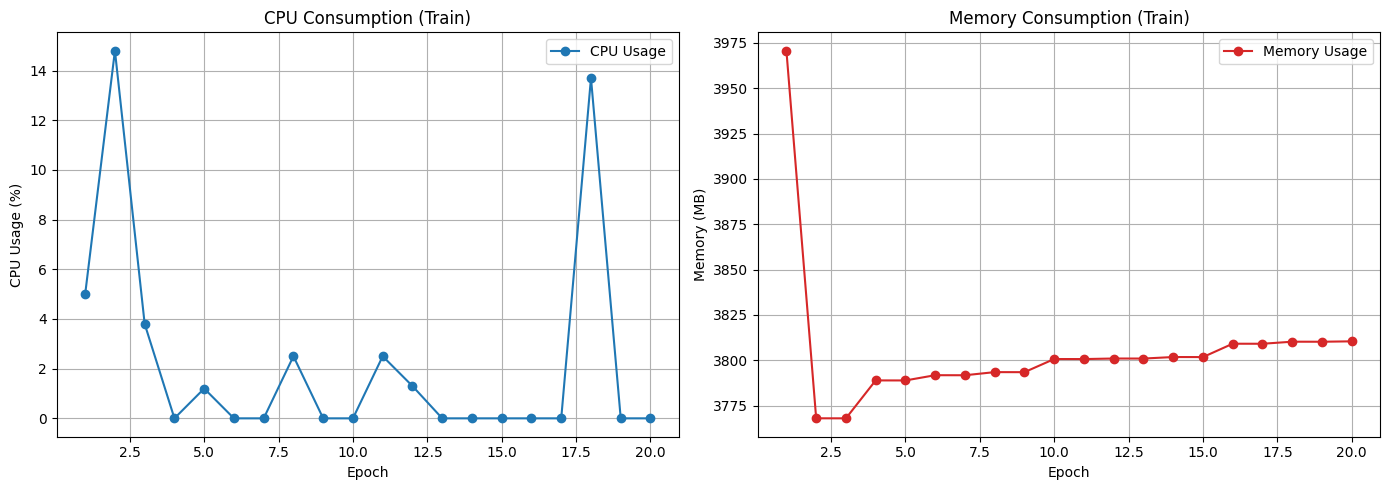

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 8s 998us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.71 seconds
Average CPU usage (Test): 2.45%
Average memory usage (Test): 3823.45 MB
Estimated energy consumption: 1267.12 Joules


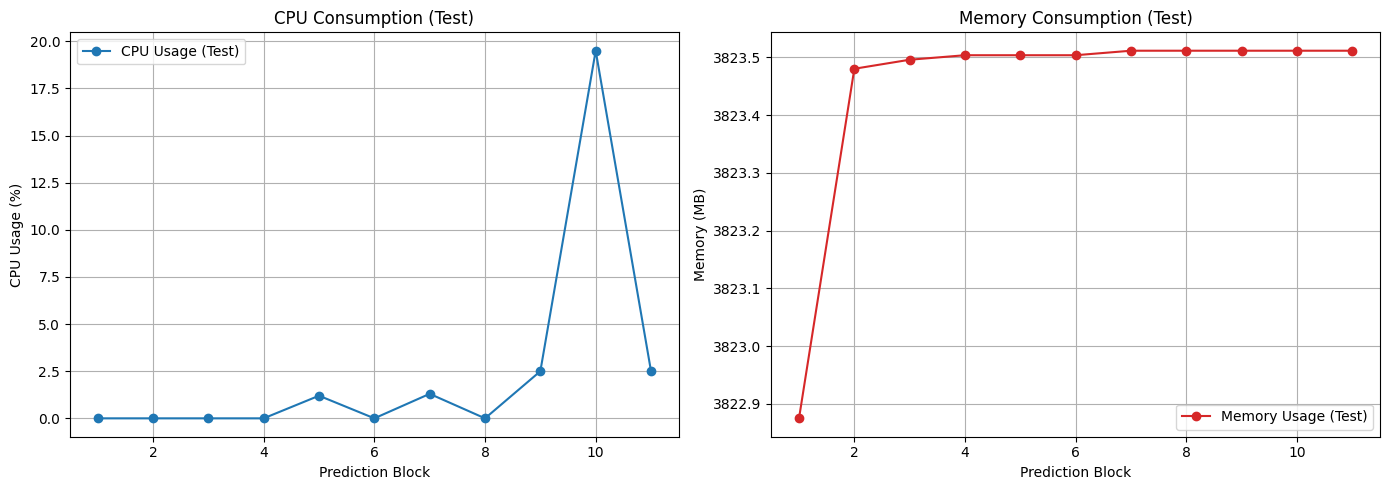

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.88 seconds
Average CPU usage (Test): 0.79%
Average memory usage (Test): 3543.11 MB
Estimated energy consumption: 7.44 Joules


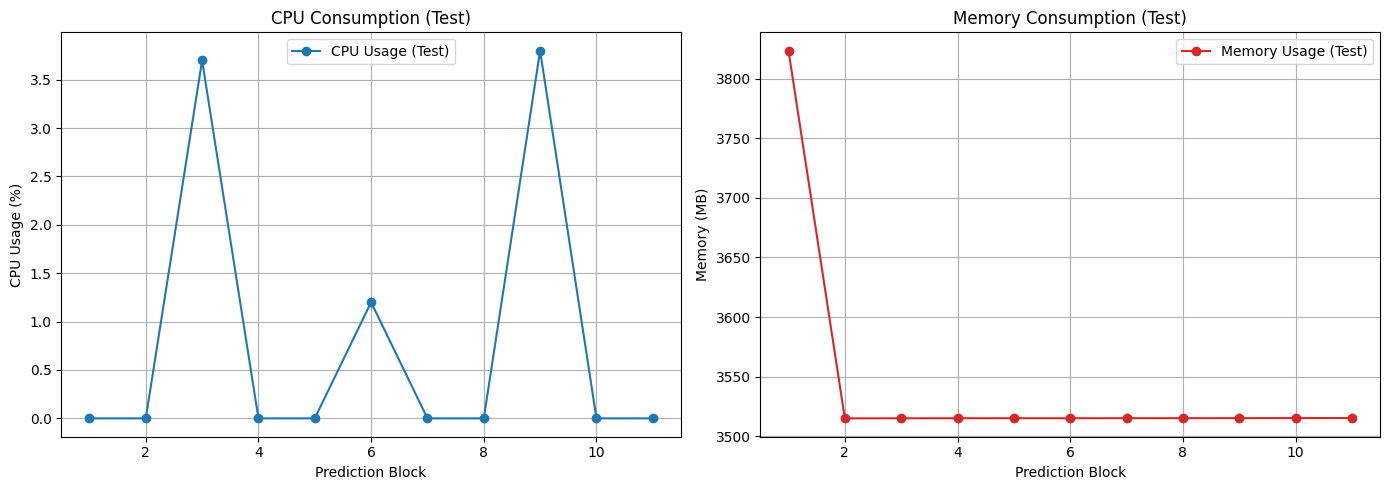

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 879us/step
✅ Curva ROC (FULL) gerada para ICMPFlood — AUC=0.9989

====== Zero-Day: UDPFlood ======
Total UDPFlood no dataset original: 457340
  Zero-day removidos do treino: 365919
  Zero-day no teste original: 91421
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3666.14 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3470.50 MB

[Epoch 2 - Início] CPU: 0.00%, Memory: 3470.48 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3490.59 MB

[Epoch 3 - Início] CPU: 0.00%, Memory: 3420.12 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3472.45 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3472.43 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3478.70 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3478.67 MB
[Epoch 5 - Fim] CPU: 14.80%, Memory: 3481.02 MB

[Epoch 6 - Início] CPU: 0.00%, Memory: 3481.00 MB
[Epoch 6 - Fim] CPU: 0.00%, Memory: 3481.26 MB

[Epoch 7 - Início] CPU: 0.00%, Memory: 3481.24 MB
[Epoch 7 - Fim] CPU: 0.00%, Memory: 3481.36 MB

[Epoch 8 -

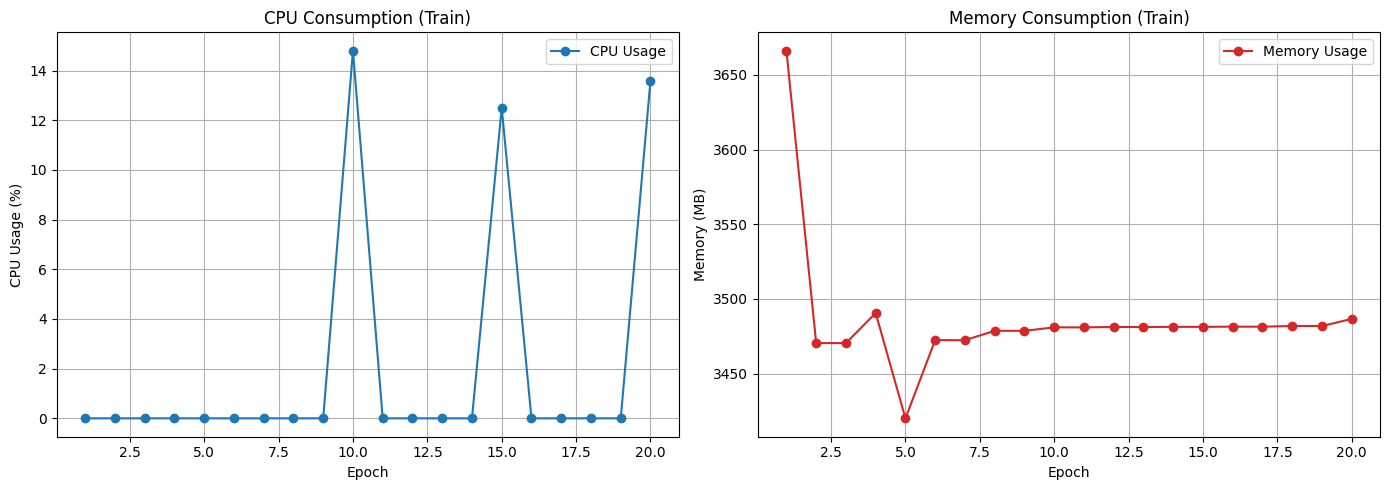

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 820us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.20 seconds
Average CPU usage (Test): 3.52%
Average memory usage (Test): 3566.81 MB
Estimated energy consumption: 3553.15 Joules


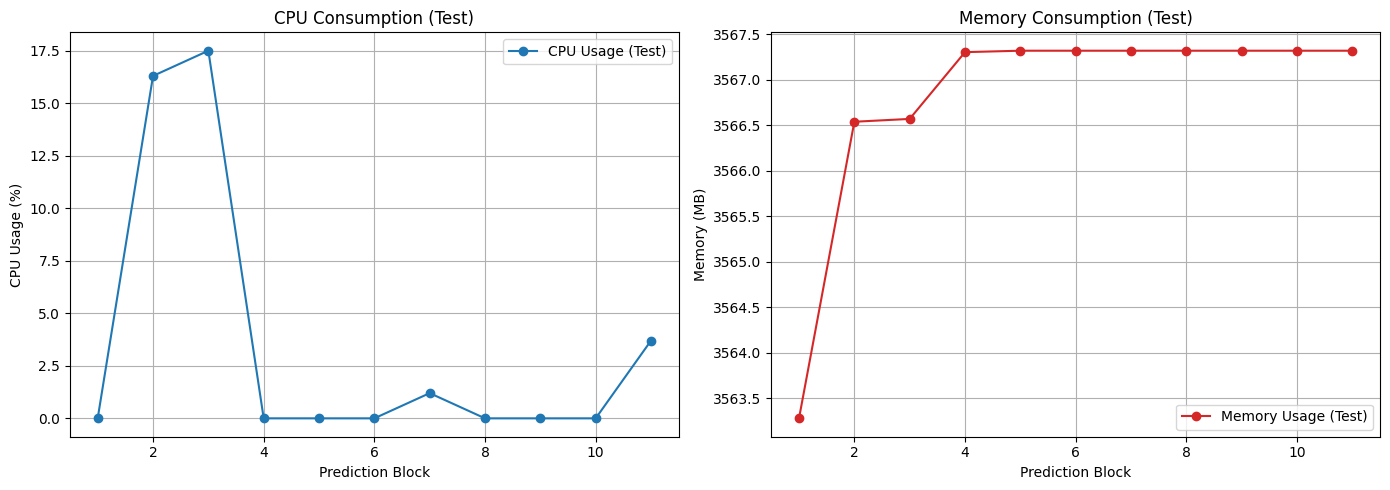

2857/2857 ━━━━━━━━━━━━━━━━━━━━ 2s 857us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 4.81 seconds
Average CPU usage (Test): 0.35%
Average memory usage (Test): 3581.61 MB
Estimated energy consumption: 1.59 Joules


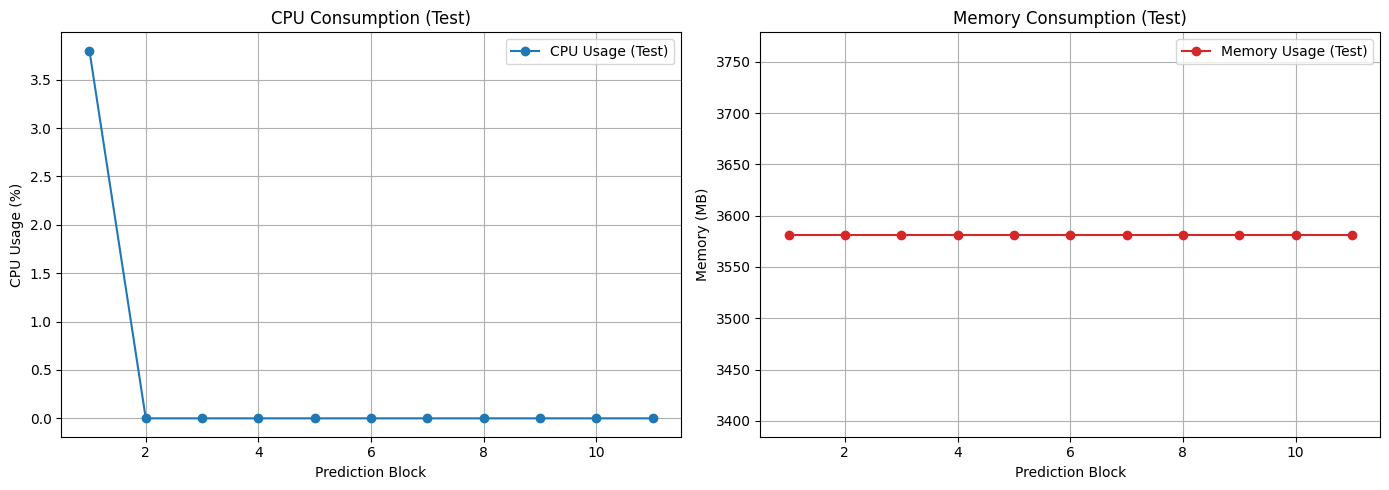

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 882us/step
✅ Curva ROC (FULL) gerada para UDPFlood — AUC=0.9260

====== Zero-Day: SYNFlood ======
Total SYNFlood no dataset original: 9721
  Zero-day removidos do treino: 7802
  Zero-day no teste original: 1919
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 4047.21 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3822.29 MB

[Epoch 2 - Início] CPU: 2.50%, Memory: 3822.32 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3846.90 MB

[Epoch 3 - Início] CPU: 3.80%, Memory: 3846.88 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3865.98 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3865.96 MB
[Epoch 4 - Fim] CPU: 15.00%, Memory: 3866.93 MB

[Epoch 5 - Início] CPU: 1.20%, Memory: 3866.91 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3870.64 MB

[End of Training]
Total time: 113.63 seconds
Average CPU usage (Training): 2.25%
Average memory usage (Training): 3872.20 MB
Estimated energy consumption: 10354.93 Joules


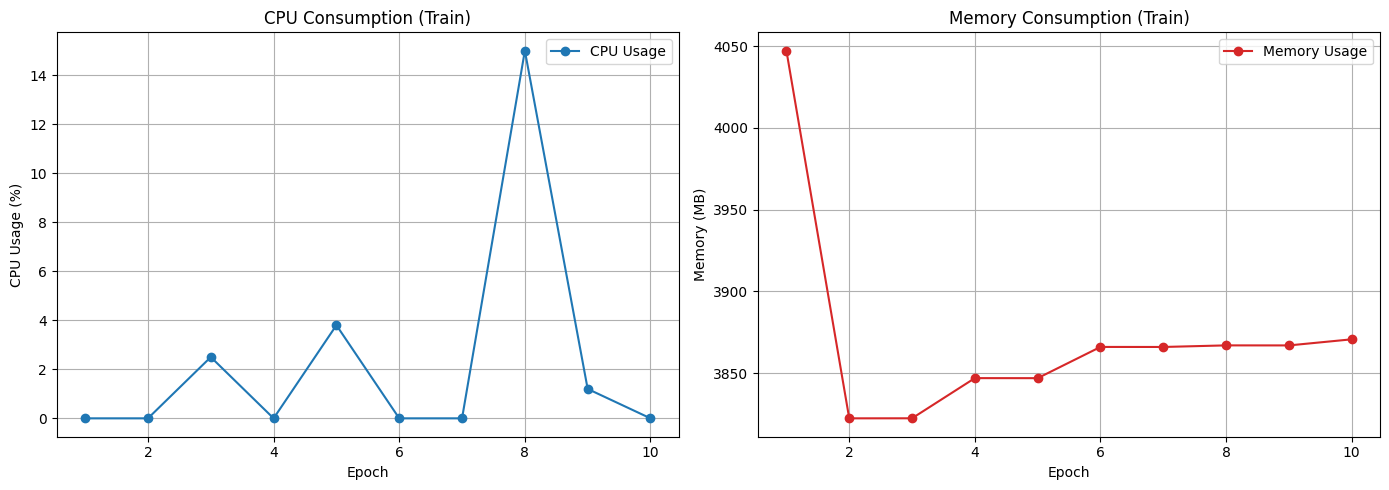

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 837us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.03 seconds
Average CPU usage (Test): 1.37%
Average memory usage (Test): 3725.27 MB
Estimated energy consumption: 207.63 Joules


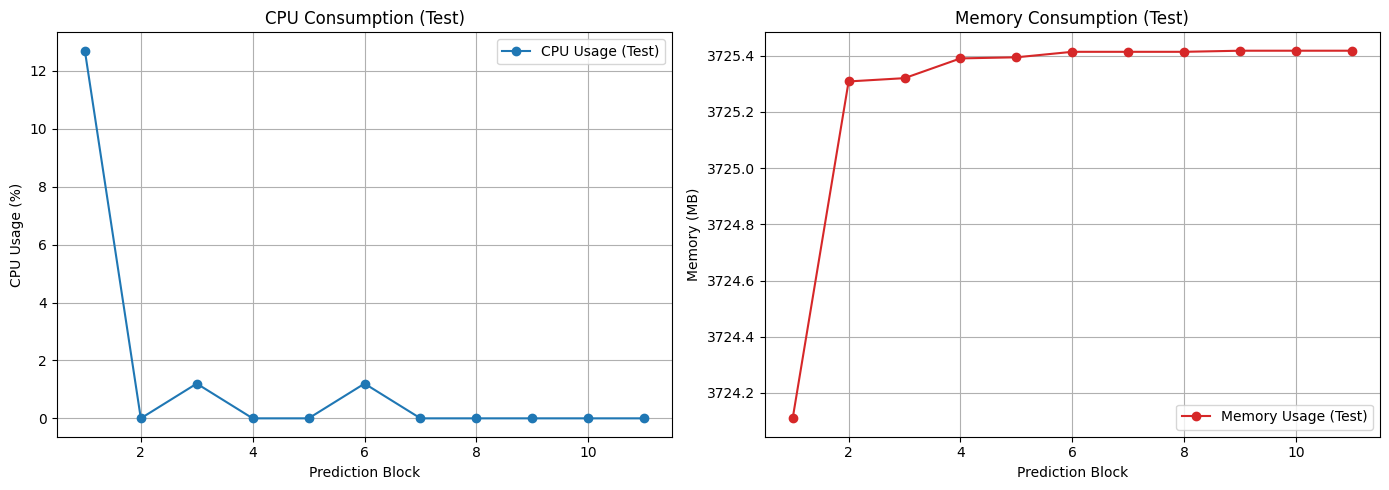

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.89 seconds
Average CPU usage (Test): 10.64%
Average memory usage (Test): 3570.07 MB
Estimated energy consumption: 18149.17 Joules


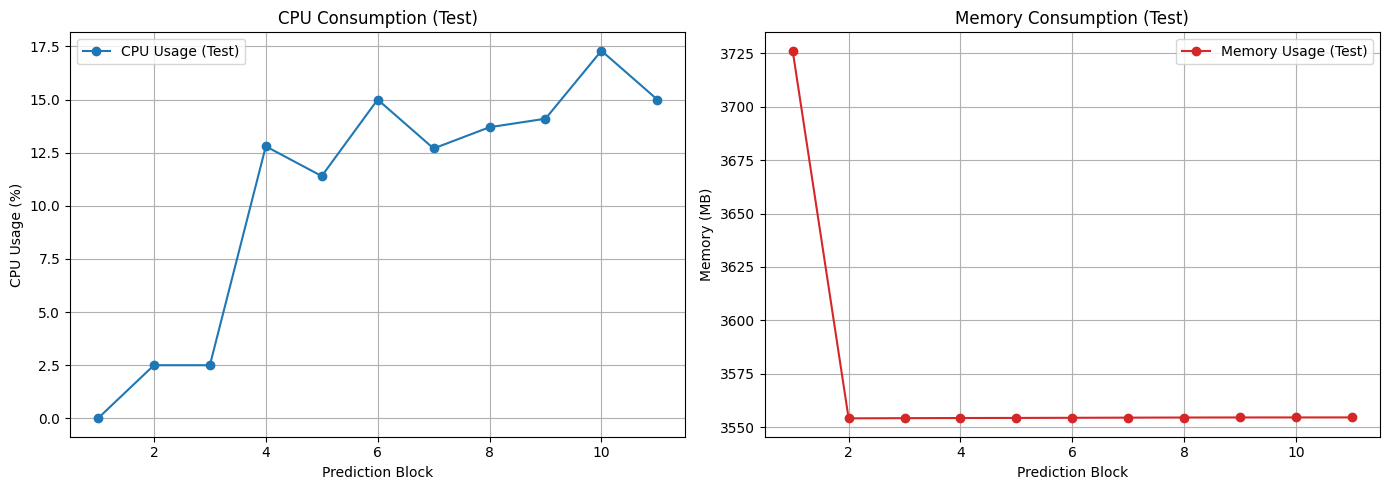

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 852us/step
✅ Curva ROC (FULL) gerada para SYNFlood — AUC=0.9994

====== Zero-Day: SYNScan ======
Total SYNScan no dataset original: 20043
  Zero-day removidos do treino: 16149
  Zero-day no teste original: 3894
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 4063.87 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3764.52 MB

[Epoch 2 - Início] CPU: 1.20%, Memory: 3764.50 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3816.22 MB

[Epoch 3 - Início] CPU: 0.00%, Memory: 3816.20 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3823.96 MB

[Epoch 4 - Início] CPU: 1.30%, Memory: 3823.94 MB
[Epoch 4 - Fim] CPU: 4.90%, Memory: 3826.89 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3826.87 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3829.88 MB

[End of Training]
Total time: 113.56 seconds
Average CPU usage (Training): 0.74%
Average memory usage (Training): 3835.68 MB
Estimated energy consumption: 368.14 Joules


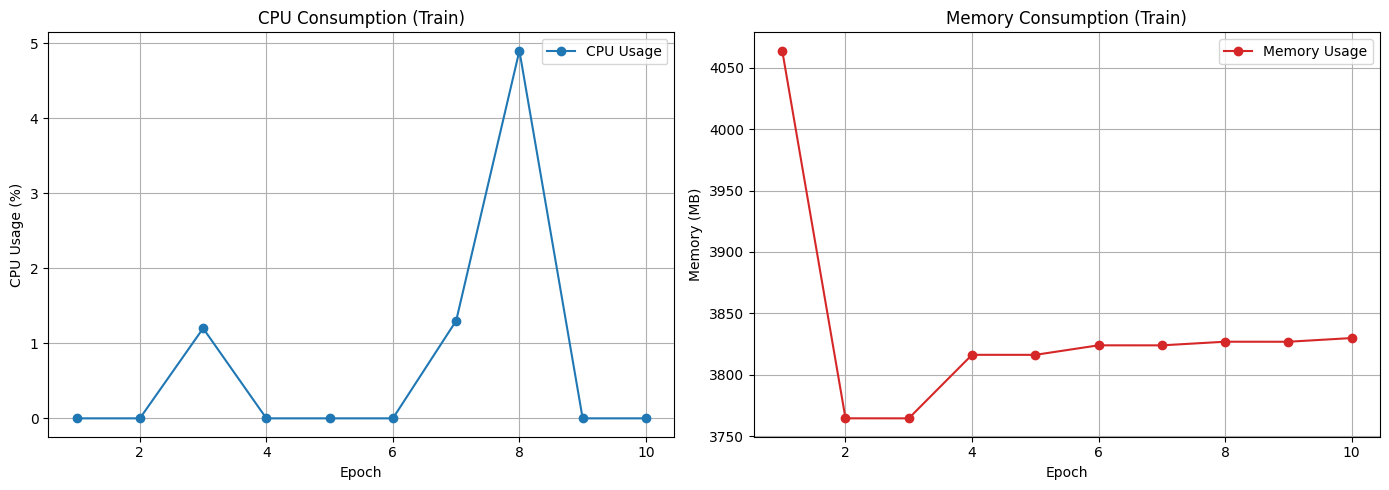

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 860us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.27 seconds
Average CPU usage (Test): 2.48%
Average memory usage (Test): 3709.15 MB
Estimated energy consumption: 1256.03 Joules


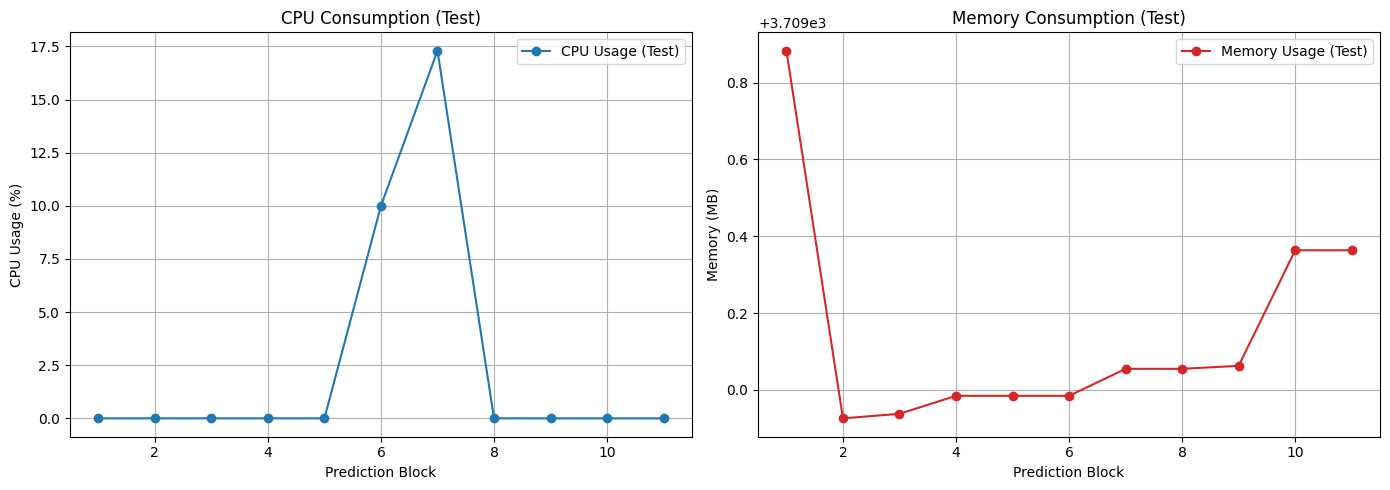

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.96 seconds
Average CPU usage (Test): 1.15%
Average memory usage (Test): 3709.38 MB
Estimated energy consumption: 24.18 Joules


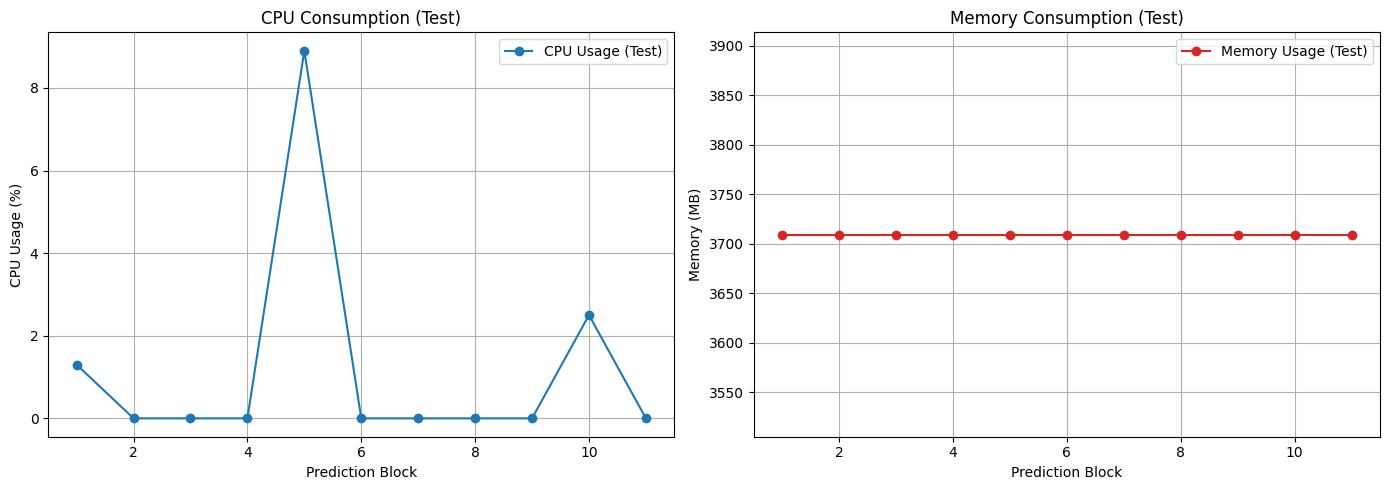

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 829us/step
✅ Curva ROC (FULL) gerada para SYNScan — AUC=0.9997

====== Zero-Day: HTTPFlood ======
Total HTTPFlood no dataset original: 140812
  Zero-day removidos do treino: 112649
  Zero-day no teste original: 28163
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3956.84 MB
[Epoch 1 - Fim] CPU: 1.20%, Memory: 3704.56 MB

[Epoch 2 - Início] CPU: 13.70%, Memory: 3707.89 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3715.32 MB

[Epoch 3 - Início] CPU: 1.30%, Memory: 3715.30 MB
[Epoch 3 - Fim] CPU: 3.80%, Memory: 3717.88 MB

[Epoch 4 - Início] CPU: 1.30%, Memory: 3717.85 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3719.64 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3719.62 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3724.34 MB

[End of Training]
Total time: 94.36 seconds
Average CPU usage (Training): 2.13%
Average memory usage (Training): 3739.92 MB
Estimated energy consumption: 7295.01 Joules


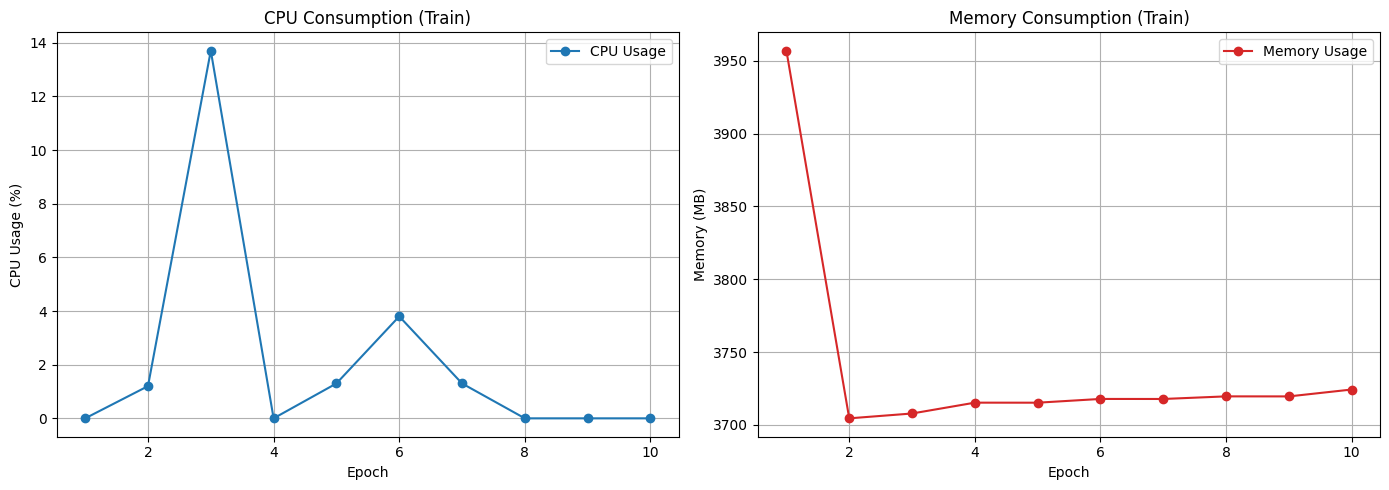

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 828us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 9.81 seconds
Average CPU usage (Test): 2.52%
Average memory usage (Test): 3633.38 MB
Estimated energy consumption: 1253.53 Joules


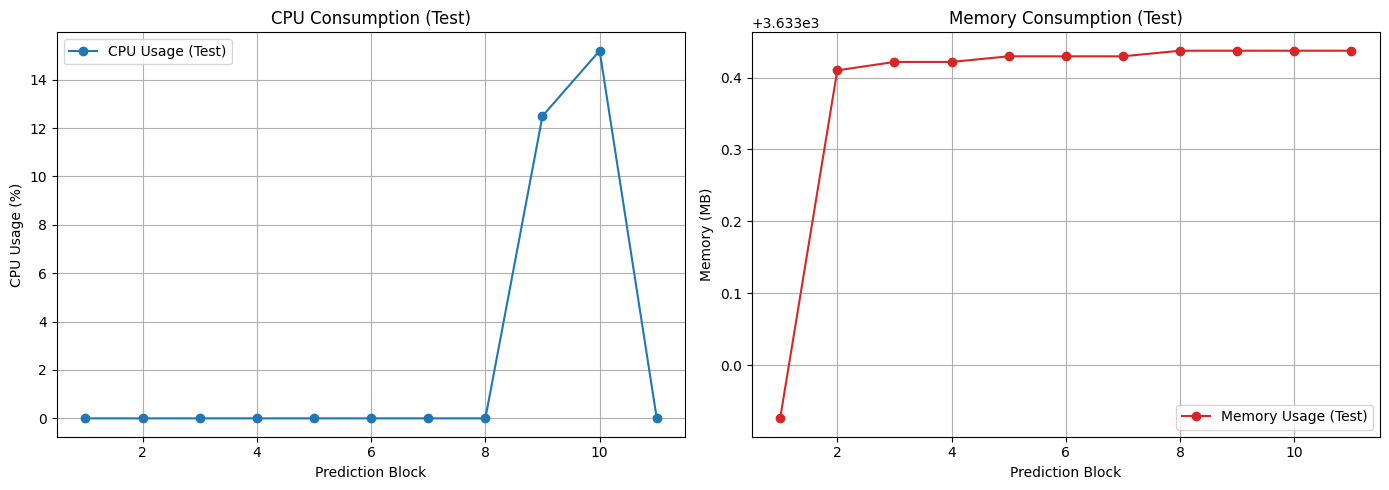

881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.74 seconds
Average CPU usage (Test): 0.91%
Average memory usage (Test): 3497.17 MB
Estimated energy consumption: 16.44 Joules


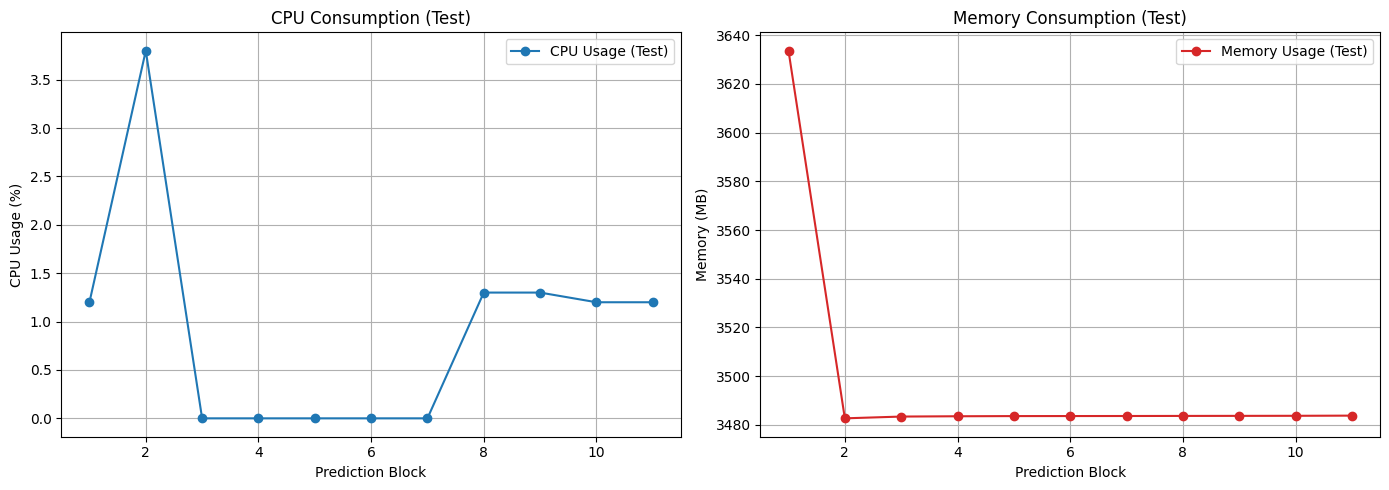

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
✅ Curva ROC (FULL) gerada para HTTPFlood — AUC=0.9564

====== Zero-Day: UDPScan ======
Total UDPScan no dataset original: 15906
  Zero-day removidos do treino: 12713
  Zero-day no teste original: 3193
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 2.50%, Memory: 4088.90 MB
[Epoch 1 - Fim] CPU: 2.50%, Memory: 3858.85 MB

[Epoch 2 - Início] CPU: 1.30%, Memory: 3858.83 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3888.58 MB

[Epoch 3 - Início] CPU: 2.50%, Memory: 3888.55 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3888.79 MB

[Epoch 4 - Início] CPU: 1.30%, Memory: 3888.77 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3891.46 MB

[Epoch 5 - Início] CPU: 1.30%, Memory: 3891.44 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3891.92 MB

[End of Training]
Total time: 113.06 seconds
Average CPU usage (Training): 1.14%
Average memory usage (Training): 3903.61 MB
Estimated energy consumption: 1339.97 Joules


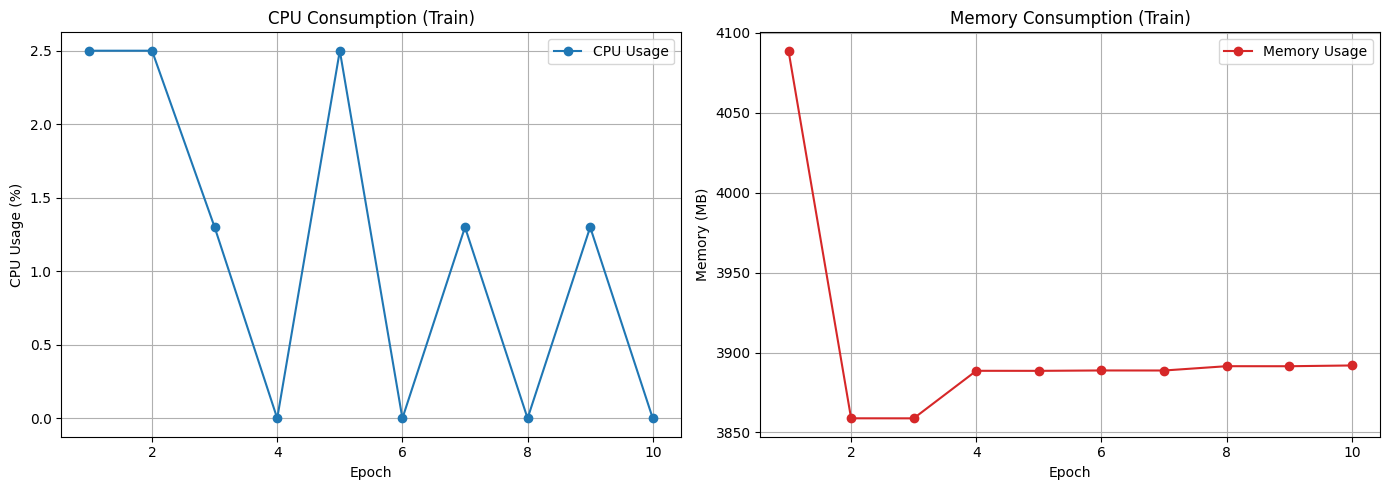

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 824us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.26 seconds
Average CPU usage (Test): 2.05%
Average memory usage (Test): 3628.31 MB
Estimated energy consumption: 711.72 Joules


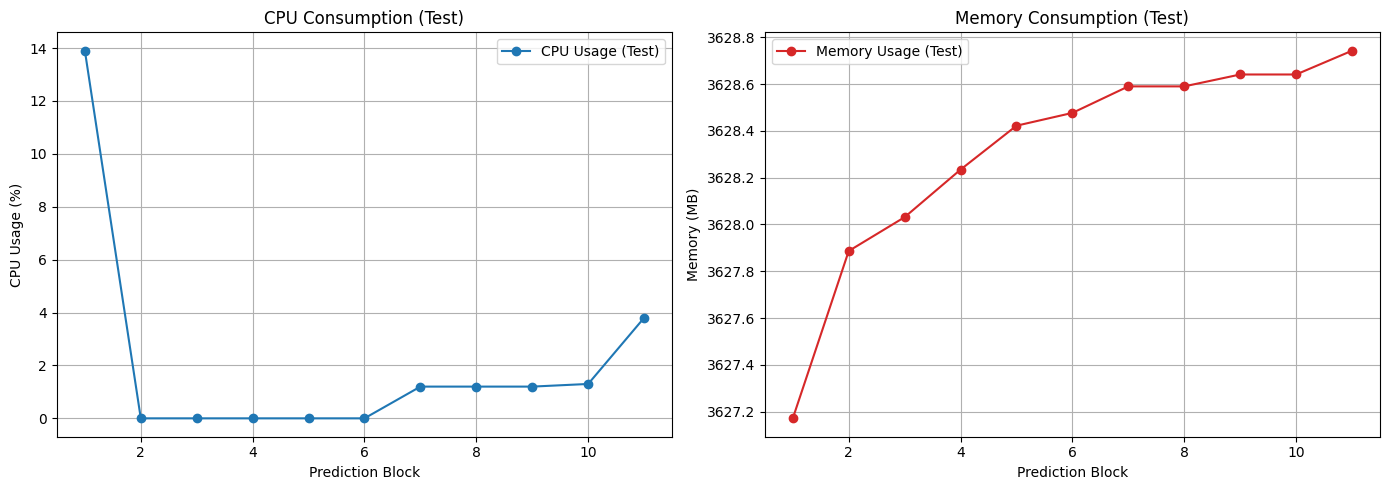

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.91 seconds
Average CPU usage (Test): 5.69%
Average memory usage (Test): 3629.20 MB
Estimated energy consumption: 2816.58 Joules


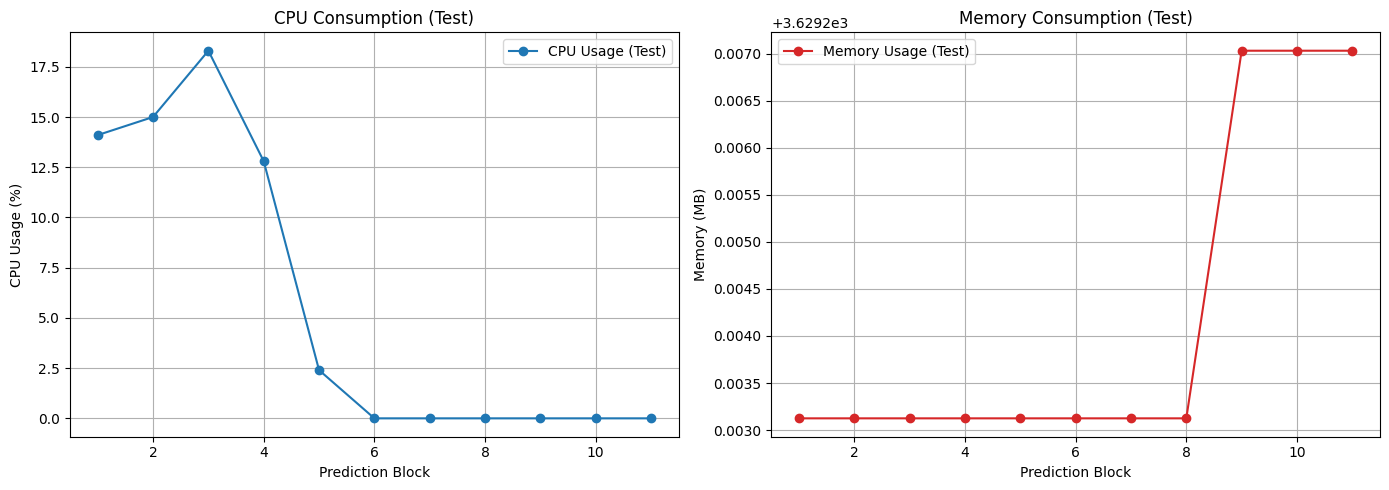

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 867us/step
✅ Curva ROC (FULL) gerada para UDPScan — AUC=0.9998

====== Zero-Day: TCPConnectScan ======
Total TCPConnectScan no dataset original: 20052
  Zero-day removidos do treino: 15999
  Zero-day no teste original: 4053
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 4097.13 MB
[Epoch 1 - Fim] CPU: 1.30%, Memory: 3834.46 MB

[Epoch 2 - Início] CPU: 5.00%, Memory: 3834.44 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3850.45 MB

[Epoch 3 - Início] CPU: 1.30%, Memory: 3850.42 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3853.79 MB

[Epoch 4 - Início] CPU: 1.30%, Memory: 3853.77 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3855.37 MB

[Epoch 5 - Início] CPU: 1.20%, Memory: 3855.34 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3855.64 MB

[End of Training]
Total time: 109.83 seconds
Average CPU usage (Training): 1.01%
Average memory usage (Training): 3874.08 MB
Estimated energy consumption: 905.30 Joules


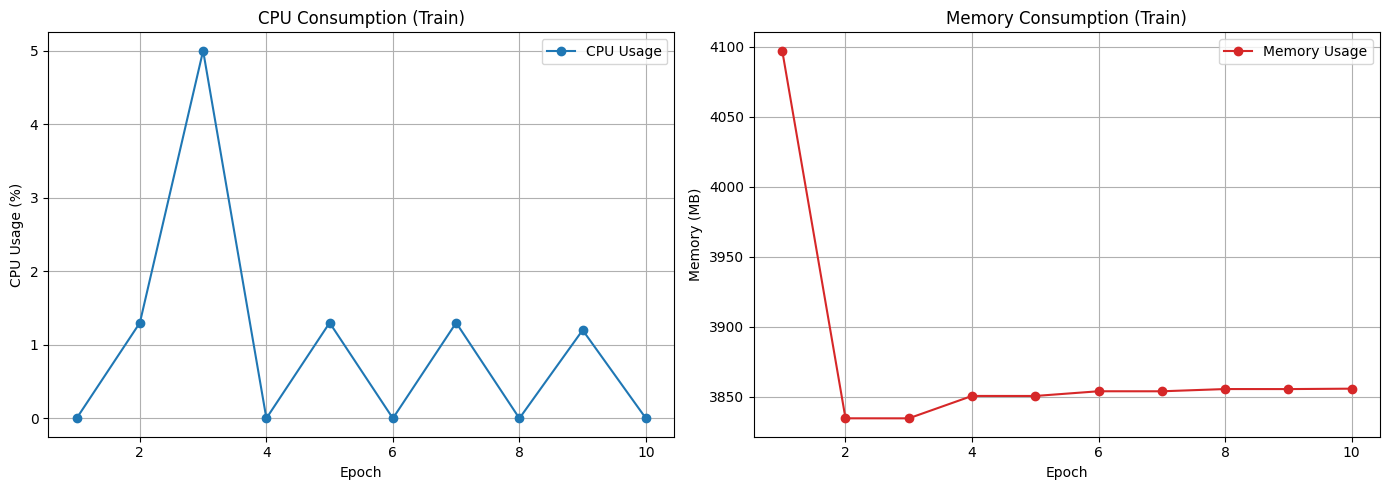

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 821us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 9.93 seconds
Average CPU usage (Test): 1.82%
Average memory usage (Test): 3741.93 MB
Estimated energy consumption: 477.37 Joules


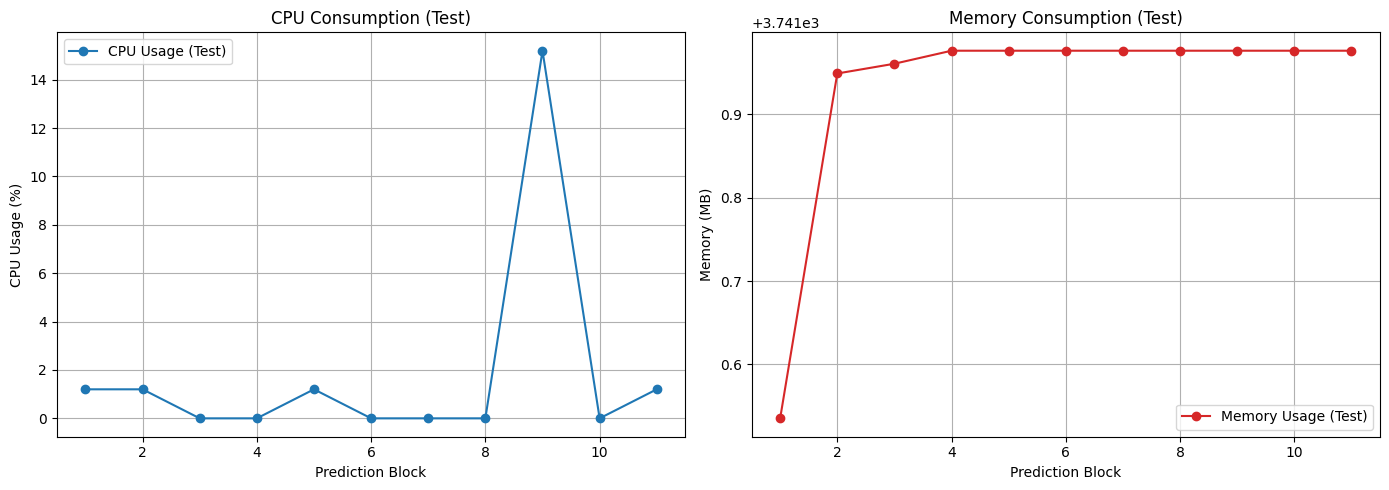

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.95 seconds
Average CPU usage (Test): 0.45%
Average memory usage (Test): 3632.70 MB
Estimated energy consumption: 1.47 Joules


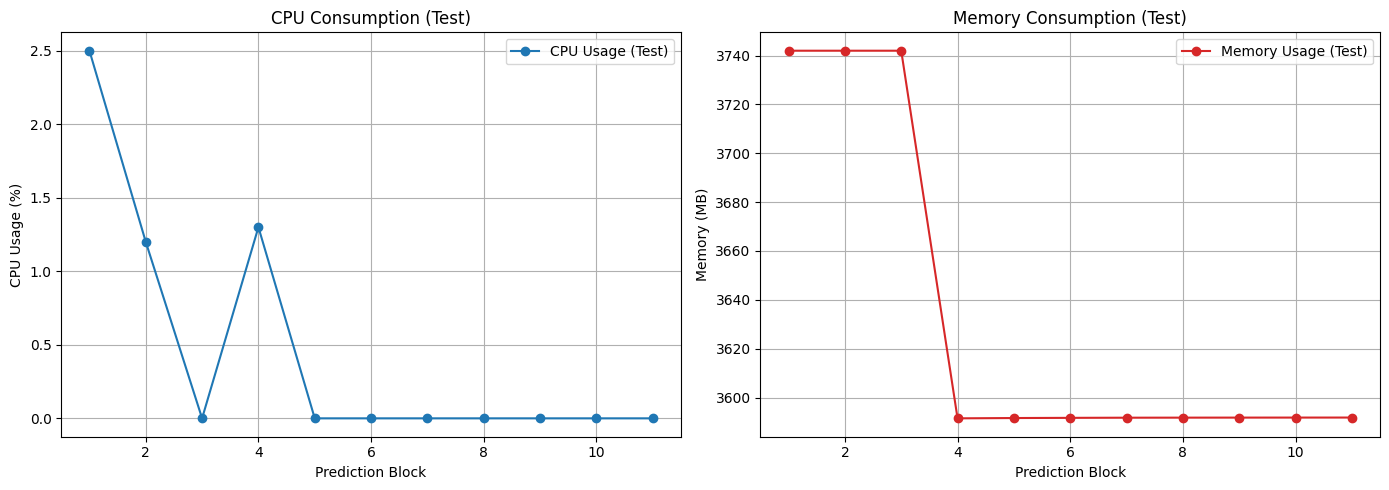

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 762us/step
✅ Curva ROC (FULL) gerada para TCPConnectScan — AUC=0.9998

====== Zero-Day: SlowrateDoS ======
Total SlowrateDoS no dataset original: 73124
  Zero-day removidos do treino: 58621
  Zero-day no teste original: 14503
  Test full total: 243178

[Início do Treinamento]

[Epoch 1 - Início] CPU: 14.80%, Memory: 4076.98 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3784.71 MB

[Epoch 2 - Início] CPU: 1.20%, Memory: 3784.69 MB
[Epoch 2 - Fim] CPU: 2.50%, Memory: 3809.76 MB

[Epoch 3 - Início] CPU: 1.30%, Memory: 3809.74 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3810.26 MB

[Epoch 4 - Início] CPU: 1.30%, Memory: 3810.23 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3812.04 MB

[Epoch 5 - Início] CPU: 15.00%, Memory: 3812.02 MB
[Epoch 5 - Fim] CPU: 2.50%, Memory: 3818.69 MB

[End of Training]
Total time: 101.48 seconds
Average CPU usage (Training): 3.86%
Average memory usage (Training): 3832.91 MB
Estimated energy consumption: 46692.15 Joules


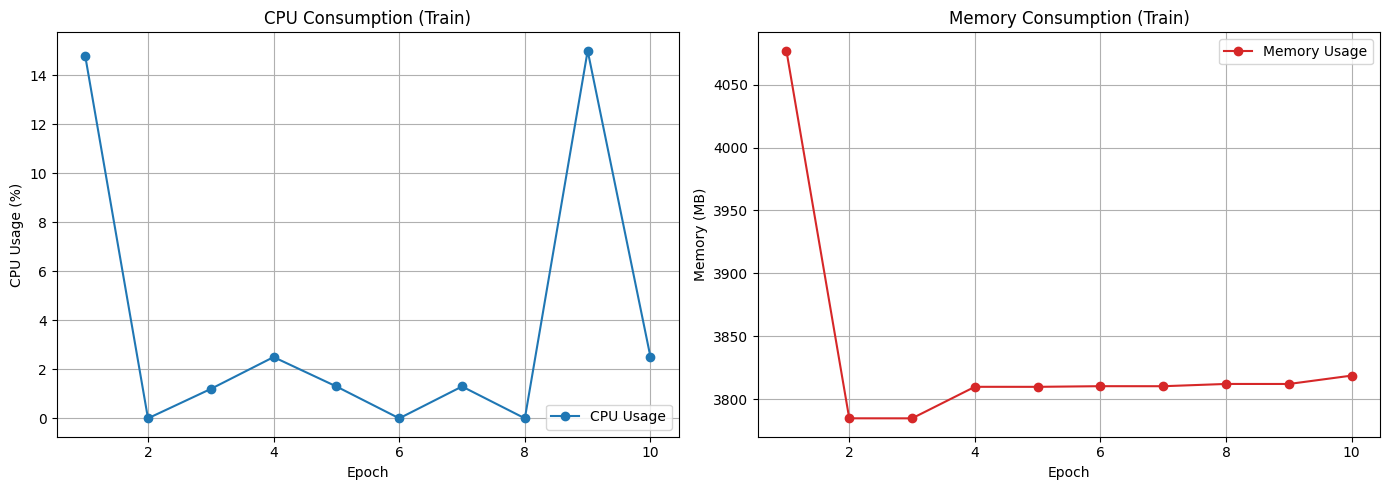

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 843us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.43 seconds
Average CPU usage (Test): 1.57%
Average memory usage (Test): 3602.09 MB
Estimated energy consumption: 324.48 Joules


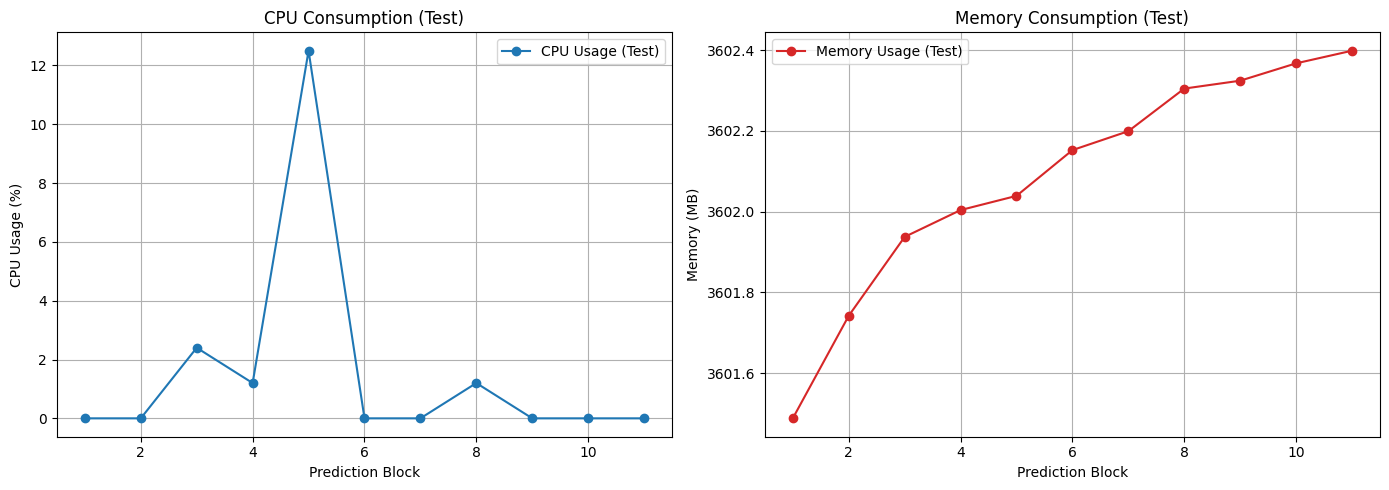

454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.36 seconds
Average CPU usage (Test): 0.90%
Average memory usage (Test): 3602.45 MB
Estimated energy consumption: 13.74 Joules


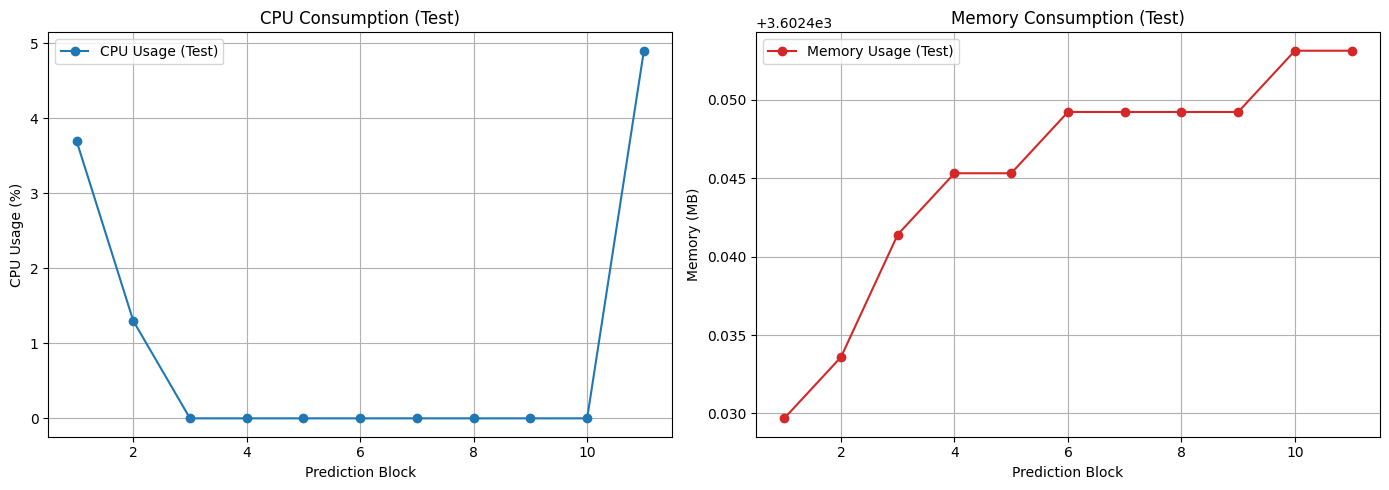

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 8s 993us/step
✅ Curva ROC (FULL) gerada para SlowrateDoS — AUC=0.9991


In [20]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['Attack Type'] = encoded.loc[X_train.index, 'Attack Type']
X_test['Attack Type'] = encoded.loc[X_test.index, 'Attack Type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['ICMPFlood', 'UDPFlood', 'SYNFlood', 'SYNScan', 'HTTPFlood', 'UDPScan', 'TCPConnectScan', 'SlowrateDoS']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

model_name = "MLP"
roc_full_curves = []

# ===== LOOP PRINCIPAL =====
for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Contagem no dataset original ---
    total_in_original = (X['Attack Type'] == ataque_zero_day).sum()
    print(f"Total {ataque_zero_day} no dataset original: {total_in_original}")
    mask_train = X_train['Attack Type'] != ataque_zero_day
    train_removed = (~mask_train).sum()

    X_train_clean = X_train.loc[mask_train].drop(columns=['Attack Type']).copy()
    y_train_clean = y_train.loc[mask_train].copy()
    print(f"  Zero-day removidos do treino: {train_removed}")

    mask_test_zero = X_test['Attack Type'] == ataque_zero_day
    X_test_zero_day = X_test.loc[mask_test_zero].drop(columns=['Attack Type']).copy()
    y_test_zero_day = y_test.loc[mask_test_zero].copy()
    print(f"  Zero-day no teste original: {mask_test_zero.sum()}")

    X_test_full = X_test.drop(columns=['Attack Type']).copy()
    y_test_full = y_test.copy()
    print(f"  Test full total: {len(X_test_full)}")

    # --- Balanceamento com SMOTE ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

    # --- Normalização ---
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # =============================
    # Codificação dos rótulos
    # =============================
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_balanced)
    y_test_full_encoded = le.transform(y_test_full)
    y_test_zero_day_encoded = le.transform(y_test_zero_day)

    # --- Construção do Modelo ---
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    # --- TREINAMENTO COM MONITORAMENTO ---
    start_time = time.time()
    history = model.fit(
        X_train_scaled, y_train_encoded,
        validation_split=0.2,
        epochs=10,
        batch_size=128,
        callbacks=[early_stopping, reduce_lr, resource_monitor],
        verbose=0
    )

    # =============================
    # TESTE GERAL COM MONITORAMENTO
    # =============================
    mstart_time = time.time()
    y_pred_full = model.predict(X_test_full_scaled)
    y_pred_full_encoded = (y_pred_full >= 0.5).astype(int).ravel()
    metrics_test_full = monitor_test_prediction(model, X_test_full_scaled)
    acc_teste_full = accuracy_score(y_test_full_encoded, y_pred_full_encoded)
    f1_teste_full = f1_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    precision_full = precision_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    recall_full = recall_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)


    # =============================
    # TESTE ZERO-DAY COM MONITORAMENTO
    # =============================
    start_time = time.time()
    y_pred_zero_day = model.predict(X_test_zero_day_scaled)
    y_pred_zero_day_encoded = (y_pred_zero_day >= 0.5).astype(int).ravel()
    metrics_zero_day = monitor_test_prediction(model, X_test_zero_day_scaled)
    acc_zero_day = accuracy_score(y_test_zero_day_encoded, y_pred_zero_day_encoded)
    f1_zero_day = f1_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    precision_zero = precision_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    recall_zero = recall_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)


    # --- Salvar resultados ---
    resultados_zero_day.append({
    'Ataque Zero-Day': ataque_zero_day,

    'Acurácia': acc_teste_full,
    'F1': f1_teste_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Tempo de Teste': metrics_test_full['total_time'],
    'CPU Teste': metrics_test_full['avg_cpu'],
    'Memória Teste': metrics_test_full['avg_mem'],
    'Energia Teste': metrics_test_full['energia'],

    'ZD - Acurácia': acc_zero_day,
    'ZD- F1': f1_zero_day,
    'ZD - Precision': precision_zero,
    'ZD - Recall': recall_zero,
    'ZD - Tempo de Teste': metrics_zero_day['total_time'],
    'ZD - CPU Teste': metrics_zero_day['avg_cpu'],
    'ZD - Memória Teste': metrics_zero_day['avg_mem'],
    'ZD - Energia Teste': metrics_zero_day['energia'],
})
    # =============================
    # CURVA ROC (gerada no mesmo loop)
    # =============================
    # TESTE FULL
    probs_full = model.predict(X_test_full_scaled).ravel()
    fpr_full, tpr_full, _ = roc_curve(y_test_full_encoded, probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    # Guarda a curva na lista (com label do ataque)
    roc_full_curves.append((fpr_full, tpr_full, roc_auc_full, f"{ataque_zero_day}"))

    print(f"✅ Curva ROC (FULL) gerada para {ataque_zero_day} — AUC={roc_auc_full:.4f}")

    del model
    gc.collect()
    K.clear_session()

/tmp/ipython-input-1070250525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(roc_full_curves))


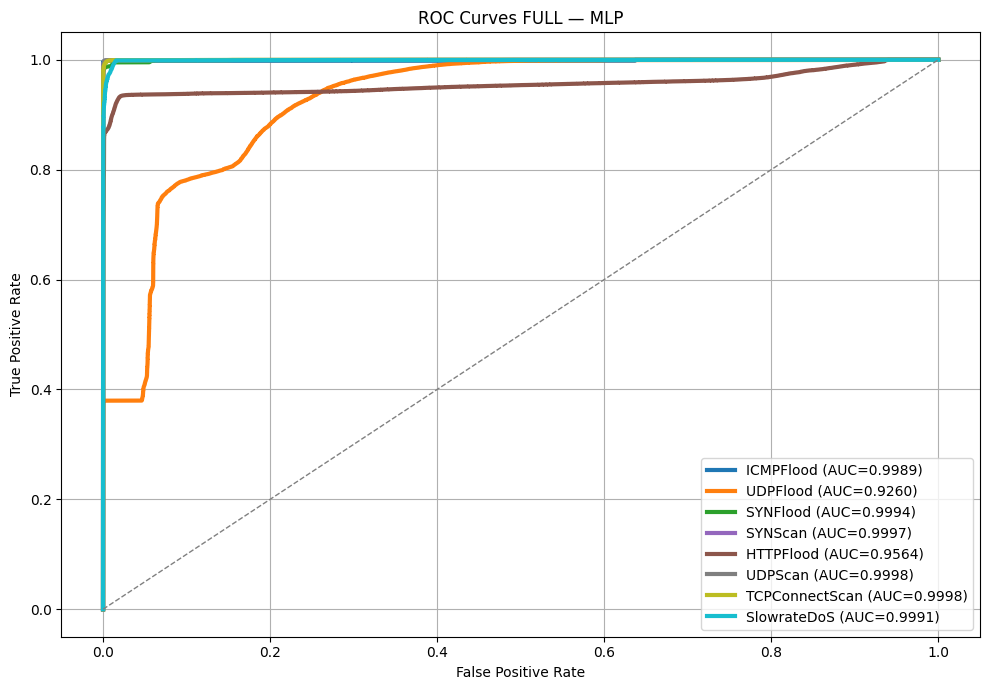

In [21]:
# =========================================
# Após o loop, gera um gráfico com todas as curvas FULL
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(roc_full_curves))

for i, (fpr, tpr, auc_val, label) in enumerate(roc_full_curves):
    plt.plot(fpr, tpr, lw=3, color=colors(i), label=f"{label} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves FULL — {model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
os.makedirs("roc_curves", exist_ok=True)
plt.savefig(f"roc_curves/{model_name}_ALL_FULL_ROC.png", dpi=400)
plt.show()

In [22]:
!pip install tabulate

In [23]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤══════════════════╤═════════════╤═════════════════╤═════════════════╤═════════════════╤══════════╤══════════════════╤═══════════════╤═══════════════════════╤══════════════════╤══════════════════════╤══════════════════════╕
│ Ataque Zero-Day   │   Acurácia │       F1 │   Precision │   Recall │   Tempo de Teste │   CPU Teste │   Memória Teste │   Energia Teste │   ZD - Acurácia │   ZD- F1 │   ZD - Precision │   ZD - Recall │   ZD - Tempo de Teste │   ZD - CPU Teste │   ZD - Memória Teste │   ZD - Energia Teste │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪══════════════════╪═════════════╪═════════════════╪═════════════════╪═════════════════╪══════════╪══════════════════╪═══════════════╪═══════════════════════╪══════════════════╪══════════════════════╪══════════════════════╡
│ ICMPFlood         │   0.998084 │ 0.998418 │    0.999375 │ 0.997462 │         10.7106  │     2.45455 │         3823.45 │

In [24]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')